# Ideas

* Correlate `elapsed_time` between first case and `mandate_when` with `cases_per_million`
* Correlate `mask_mandate` with `pos_cases_per_tests`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sqlalchemy as sq
location = 'sqlite:///data/nyt_covid.db'
engine = sq.create_engine(location)
engine.table_names()

['county_covid_dates', 'county_dataset', 'state_dataset']

In [3]:
cnx = sq.create_engine(location)
df_cdates = pd.read_sql_table('county_covid_dates', cnx, parse_dates='date')
df_county = pd.read_sql_table('county_dataset', cnx)
df_state = pd.read_sql_table('state_dataset', cnx)

# Analysis

## Covid Over Time

In [4]:
df_cdates.head()

,date,state,county,fips,covid_cases,covid_deaths
0,2020-01-21,Washington,Snohomish,53061.0,1,0
1,2020-01-22,Washington,Snohomish,53061.0,1,0
2,2020-01-23,Washington,Snohomish,53061.0,1,0
3,2020-01-24,Illinois,Cook,17031.0,1,0
4,2020-01-24,Washington,Snohomish,53061.0,1,0


<AxesSubplot:xlabel='date', ylabel='covid_cases'>

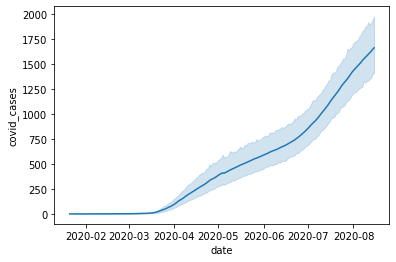

In [5]:
sns.lineplot(x='date',y='covid_cases',data=df_cdates)

## County Mask Use

NOTE: Reminder that county covid cases represent the mean of all recorded total cases in the county from August 1, 2020 onwards.

In [7]:
df_county['mask_wearer'] = (df_county['mask_always'] + df_county['mask_frequently'])*100
df_county['non_wearer'] = (df_county['mask_rarely'] + df_county['mask_never']+ df_county['mask_sometimes'])*100

In [9]:
df_county.head()

,state,region,county,division,area_type,population,covid_cases,covid_deaths,cases_per_million,cases_per_hthousand,...,domestic_migration,birth_rate,death_rate,fips,sumlev,region_fips,division_fips,mask_wearer,non_wearer,who_wears_masks
0,Alabama,south,Autauga,east_south_central,county_or_equiv,55869.0,1161.857143,22.142857,20796.096992,2079.609699,...,270.0,11.202671,9.712572,1001.0,50.0,3.0,6.0,73.9,26.1,majority
1,Alabama,south,Baldwin,east_south_central,county_or_equiv,223234.0,3579.142857,27.571429,16033.143953,1603.314395,...,5297.0,10.446871,10.546624,1003.0,50.0,3.0,6.0,75.9,24.0,majority
2,Alabama,south,Barbour,east_south_central,county_or_equiv,24686.0,631.571429,5.357143,25584.194627,2558.419463,...,-141.0,10.331329,12.591307,1005.0,50.0,3.0,6.0,69.2,30.8,majority
3,Alabama,south,Bibb,east_south_central,county_or_equiv,22394.0,432.714286,4.714286,19322.777785,1932.277778,...,31.0,10.723621,11.259802,1007.0,50.0,3.0,6.0,85.0,15.0,majority
4,Alabama,south,Blount,east_south_central,county_or_equiv,57826.0,913.714286,3.928571,15801.097875,1580.109787,...,59.0,11.263268,11.367077,1009.0,50.0,3.0,6.0,65.3,34.7,plurality


Text(0.5, 1.0, 'Mean of total county covid cases per thousand')

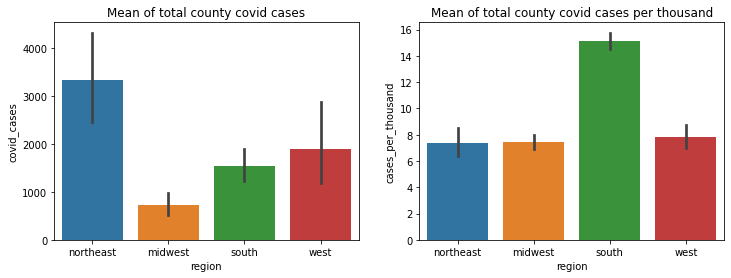

In [42]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))

sns.barplot(x='region',y='covid_cases',data=df_county, order=['northeast','midwest','south','west'], ax=ax1)
ax1.set_title('Mean of total county covid cases')

sns.barplot(x='region',y='cases_per_thousand',data=df_county, order=['northeast','midwest','south','west'], ax=ax2)
ax2.set_title('Mean of total county covid cases per thousand')

__Takeaway:__ While the Northeast US has the most number of cases, the South has the greatest `cases_per_thousand` by more than 100%

To find out whether a state's citizens are wearing masks in general we performed the following:

1. Grouped `df_county` by state, aggregating `mask_wearer` columns by the mean. For the state of Alabama, for example, an average of 69% of respondents in each county responded that they "always" or "frequently" wear a mask when going outside their home.
2. We set up rules to categorize each state according to the mean of counties who answered they "always" or "frequently" wear masks outside the home: 
    * If the mean is around 70% or more, the `who_wears_masks` is set to majority. 
    * If the mean is between 50% and 70%, it is set to plurality. 
    * If the mean is between 30% and 50% the column is set to minority. 
    * If the mean is less than 30% the column is set to rarity.

This allows us to further compare states where the majority of citizens wear masks versus those that do not.

In [6]:
def mask_cat(num):
    if round(num) >= 69:
        return "majority"
    elif (round(num) > 50) & (round(num) < 69):
        return "plurality"
    elif (round(num) >= 30) & (round(num) <= 50):
        return "minority"
    else:
        return "rarity"

In [ ]:
df_county['who_wears_masks'] = df_county['mask_wearer'].apply(mask_cat)

In [8]:
df_county.groupby('who_wears_masks').mean()

,population,covid_cases,covid_deaths,cases_per_million,cases_per_hthousand,cases_per_thousand,cases_per_hundred,mask_never,mask_rarely,mask_sometimes,...,intnl_migration,domestic_migration,birth_rate,death_rate,fips,sumlev,region_fips,division_fips,mask_wearer,non_wearer
who_wears_masks,,,,,,,,,,,,,,,,,,,,,
majority,154135.613555,2353.723128,70.495588,11789.463761,1178.946376,11.789464,1.178946,0.048833,0.054173,0.092831,...,279.495244,188.736623,10.716178,10.176622,30725.397422,49.964328,2.678954,5.172414,80.414930,19.583781
minority,16223.840426,140.804075,1.511260,6817.949834,681.794983,6.817950,0.681795,0.179044,0.167089,0.195236,...,8.452128,-8.856383,11.726427,10.534604,32550.724138,50.000000,2.473404,4.904255,45.869458,54.136946
plurality,28785.994030,335.710784,6.167390,10464.655316,1046.465532,10.464655,1.046466,0.114973,0.117223,0.157633,...,12.454726,26.408955,11.190999,11.043068,29349.339658,50.000000,2.591045,5.037811,61.016034,38.982922
rarity,21843.500000,57.142857,0.071429,2728.161446,272.816145,2.728161,0.272816,0.364000,0.155000,0.209000,...,-9.000000,18.000000,11.926727,12.358913,29222.000000,50.000000,2.000000,4.000000,27.200000,72.800000


Text(0.5, 1.0, 'Mean of total county cases per thousand in each region')

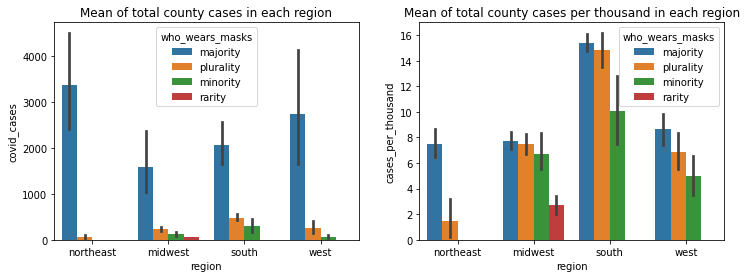

In [51]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))

sns.barplot(x='region',y='covid_cases',hue='who_wears_masks', data=df_county, order=['northeast','midwest','south','west'], ax=ax1)
ax1.set_title('Mean of total county cases in each region')

sns.barplot(x='region',y='cases_per_thousand',hue='who_wears_masks', data=df_county, order=['northeast','midwest','south','west'], ax=ax2)
ax2.set_title('Mean of total county cases per thousand in each region')

__Takeaway:__ More people wear masks if the `cases_per_thousand` is higher. This may indicate that people are more likely to wear masks in the presence of urgency.

## State Mask Use

In [12]:
df_state['pop_density'] = df_state['population']/df_state['land_area_sqmi']
df_state['covid_per_density'] = df_state['covid_cases']/df_state['pop_density']

In [13]:
df_state['covid_per_sqmi'] = df_state['covid_cases']/df_state['land_area_sqmi']

In [14]:
df_graph = df_state[(df_state['state']=='Ohio')|
              (df_state['state']=='New Hampshire')|
              (df_state['state']=='Texas')|
              (df_state['state']=='Massachusetts')|
              (df_state['state']=='California')|
              (df_state['state']=='Florida')]

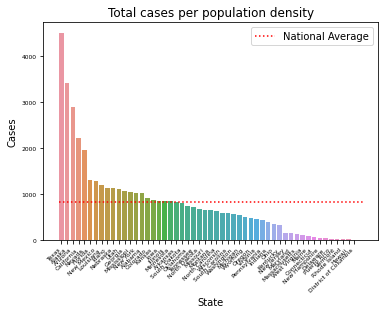

In [30]:
ax = sns.barplot(x='state',y='covid_per_density',data=df_state.sort_values('covid_per_density', ascending=False))
plt.xlabel('State')
plt.ylabel('Cases')
plt.title('Total cases per population density')
plt.xticks(rotation=45, horizontalalignment='right',)
plt.hlines(df_state['covid_per_density'].mean(),-0.5,52.5,linestyles=':',color='red',label='National Average')
plt.legend()

ax.tick_params(axis = 'both', which = 'major', labelsize = 6)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 6)

# plt.savefig('exports/all_states_avg.png',dpi=300, bbox_inches='tight')

The populations of each state differ, but the raw numbers are hard to interpret. For this reason each state is categorized into size.

Based on this boxplot the following seems reasonable:
* `small`: less than 2 million
* `medium`: 2 million - 10 million
* `large`: greater than 10 million

In [16]:
def pop_size_cat(cell):
    '''
    Categorizes each state by their size
    '''
    if pd.isnull(cell):
        return 'no data'
    elif cell < 2000000:
        return 'small'
    elif cell > 10000000:
        return 'large'
    elif (cell > 2000000) & (cell < 10000000):
        return 'medium'
    else:
        return 'no data'

In [17]:
df_state['pop_size'] = df_state['population'].apply(pop_size_cat)

In [18]:
df_state['pop_in_mill'] = df_state['population']/1000000

In [19]:
df_state.groupby('pop_size').mean()[['pop_in_mill','cases_per_million']]

,pop_in_mill,cases_per_million
pop_size,,
large,18.634202,15826.342840
medium,5.239404,14128.267626
small,1.134805,8928.671871


In [20]:
state_order = ['small','medium','large']

Text(0, 0.5, 'Total Cases')

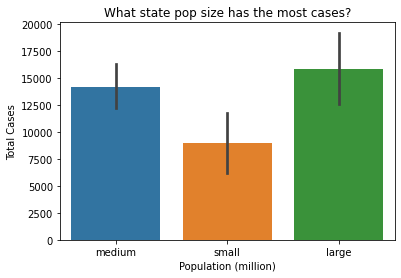

In [21]:
g = sns.barplot(x='pop_size',y='cases_per_million',data=df_state,hue_order=state_order)
#plt.hlines(df_state['non_wearer'].mean(),-0.5,3.5,linestyles='--',color='red',label='National Average')
plt.title('What state pop size has the most cases?')
plt.xlabel('Population (million)')
plt.ylabel('Total Cases')

In [22]:
# column to categorize counties is mask wearers or not
df_county['major_masks'] = df_county['mask_wearer'].apply(lambda x: 1 if x > 70 else 0)
df_county.head()

,state,region,county,division,area_type,population,covid_cases,covid_deaths,cases_per_million,cases_per_hthousand,...,birth_rate,death_rate,fips,sumlev,region_fips,division_fips,mask_wearer,non_wearer,who_wears_masks,major_masks
0,Alabama,south,Autauga,east_south_central,county_or_equiv,55869.0,1161.857143,22.142857,20796.096992,2079.609699,...,11.202671,9.712572,1001.0,50.0,3.0,6.0,73.9,26.1,majority,1
1,Alabama,south,Baldwin,east_south_central,county_or_equiv,223234.0,3579.142857,27.571429,16033.143953,1603.314395,...,10.446871,10.546624,1003.0,50.0,3.0,6.0,75.9,24.0,majority,1
2,Alabama,south,Barbour,east_south_central,county_or_equiv,24686.0,631.571429,5.357143,25584.194627,2558.419463,...,10.331329,12.591307,1005.0,50.0,3.0,6.0,69.2,30.8,majority,0
3,Alabama,south,Bibb,east_south_central,county_or_equiv,22394.0,432.714286,4.714286,19322.777785,1932.277778,...,10.723621,11.259802,1007.0,50.0,3.0,6.0,85.0,15.0,majority,1
4,Alabama,south,Blount,east_south_central,county_or_equiv,57826.0,913.714286,3.928571,15801.097875,1580.109787,...,11.263268,11.367077,1009.0,50.0,3.0,6.0,65.3,34.7,plurality,0


In [129]:
state_mask = df_county.groupby('state').mean()[['mask_wearer']].reset_index()
state_mask['who_wears_masks'] = state_mask['mask_wearer'].apply(mask_cat)
state_mask.head()

,state,mask_wearer,who_wears_masks
0,Alabama,69.059091,majority
1,Arizona,79.853846,majority
2,Arkansas,68.237500,plurality
3,California,86.645455,majority
4,Colorado,79.688889,majority


In [130]:
df_state_mask = df_state[['state','region','division','covid_cases','covid_deaths',
                          'covid_per_density','population','pop_density','cases_per_thousand']].merge(state_mask, on='state')
df_state_mask.head()

,state,region,division,covid_cases,covid_deaths,covid_per_density,population,pop_density,cases_per_thousand,mask_wearer,who_wears_masks
0,Alabama,south,east_south_central,99287.533333,1760.066667,1025.540975,4903185,96.814789,20.249600,69.059091,majority
1,Arizona,west,mountain,185412.733333,4099.333333,2893.610787,7278717,64.076597,25.473271,79.853846,majority
2,Arkansas,south,west_south_central,48281.200000,531.533333,832.496823,3017804,57.995657,15.998786,68.237500,plurality
3,California,west,pacific,560676.533333,10266.200000,2210.496476,39512223,253.642808,14.189952,86.645455,majority
4,Colorado,west,mountain,50269.933333,1866.600000,904.725695,5758736,55.563729,8.729335,79.688889,majority


In [131]:
df_state_mask['who_wears_masks'].unique()

array(['majority', 'plurality'], dtype=object)

<AxesSubplot:xlabel='who_wears_masks', ylabel='cases_per_thousand'>

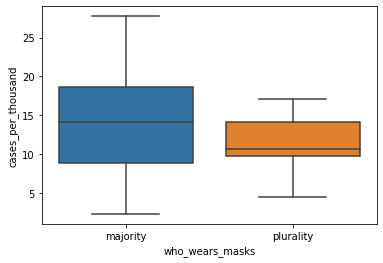

In [132]:
sns.boxplot(y='cases_per_thousand',data=df_state_mask, x='who_wears_masks')

__Takeaways:__

* Surprisingly enough, if we take the average of counties across states the majority does report to wear masks. Mask wearing varies by county, but not too much by state.
* You are also more likely to encounter people wearing masks in states where the `cases_per_thousand` is higher.

# Influence of Mask Mandates

* [Source 1](https://www.aarp.org/health/healthy-living/info-2020/states-mask-mandates-coronavirus.html)
* [Source 2](https://www.cnn.com/2020/06/19/us/states-face-mask-coronavirus-trnd/index.html)

Dataset collected from above sources. In situations when the date was different, the earliest date was taken. `Type` includes tags for description of mandate currently in effect.

In [133]:
df_mand = pd.read_excel('data/added_data/mask_mandates.xlsx',skiprows=2)
df_mand.columns = df_mand.columns.str.lower()

In [134]:
df_mand['type'] = df_mand['type'].str.lower()
df_mand['type_split'] = df_mand['type'].str.split(',')

In [135]:
df_graph_mand = df_state[(df_state['state']=='Ohio')|
              (df_state['state']=='New Hampshire')|
              (df_state['state']=='Texas')|
              (df_state['state']=='Massachusetts')|
              (df_state['state']=='California')|
              (df_state['state']=='Florida')]

In [136]:
def who_exempt(cell):
    if pd.isna(cell):
        return 'no mandate'
    elif 'children' in cell:
        return 'child exempt'
    elif 'toddler' in cell:
        return 'toddler exempt'
    else:
        return 'no exemptions'

In [137]:
df_mand['children_toddlers_none'] = df_mand['type'].apply(who_exempt)

In [138]:
df_mand['month_mandate'] = df_mand['date'].dt.month
df_mand['month_mandate'] = df_mand['month_mandate'].fillna('no mandate')

In [139]:
df_mand.head()

,state,mandate,date,type,type_split,children_toddlers_none,month_mandate
0,Alabama,Yes,2020-07-16,indoor and outdoor,[indoor and outdoor],no exemptions,7
1,Alaska,No,NaT,NaN,NaN,no mandate,no mandate
2,Arizona,No,NaT,NaN,NaN,no mandate,no mandate
3,Arkansas,Yes,2020-07-20,children exempt,[children exempt],child exempt,7
4,California,Yes,2020-06-18,toddlers exempt,[toddlers exempt],toddler exempt,6


In [140]:
import datetime as dt

In [141]:
df_mand['date'][0] < dt.datetime.strptime('20200718','%Y%m%d')

True

In [142]:
def mandate_when(x):
    if pd.isna(x):
        return 'No Mandate'
    elif x<dt.datetime.strptime('20200515','%Y%m%d'):
        return 'Before May 15'
    elif x>dt.datetime.strptime('20200715','%Y%m%d'):
        return 'After Jul 15'
    else:
        return 'In Between'

In [143]:
df_mand['mandate_when'] = df_mand['date'].apply(mandate_when)

In [128]:
df_state_mask

,state,region,division,covid_cases,covid_deaths,covid_per_density,population,cases_per_thousand,mask_wearer,who_wears_masks
0,Alabama,south,east_south_central,99287.533333,1760.066667,1025.540975,4903185,20.249600,69.059091,majority
1,Arizona,west,mountain,185412.733333,4099.333333,2893.610787,7278717,25.473271,79.853846,majority
2,Arkansas,south,west_south_central,48281.200000,531.533333,832.496823,3017804,15.998786,68.237500,plurality
3,California,west,pacific,560676.533333,10266.200000,2210.496476,39512223,14.189952,86.645455,majority
4,Colorado,west,mountain,50269.933333,1866.600000,904.725695,5758736,8.729335,79.688889,majority
5,Connecticut,northeast,new_england,50383.666667,4441.933333,68.425828,3565287,14.131728,90.800000,majority
6,Delaware,south,south_atlantic,15533.466667,589.200000,31.090415,973764,15.951983,91.050000,majority
7,Florida,south,south_atlantic,524503.533333,8082.666667,1309.565434,21477737,24.420801,77.461290,majority
8,Georgia,south,south_atlantic,196289.866667,4093.666667,1063.272990,10617423,18.487524,71.316561,majority
9,Hawaii,west,pacific,3320.066667,31.133333,15.061240,1415872,2.344892,92.980000,majority


In [144]:
df_mand = df_mand.merge(df_state_mask, on = 'state')

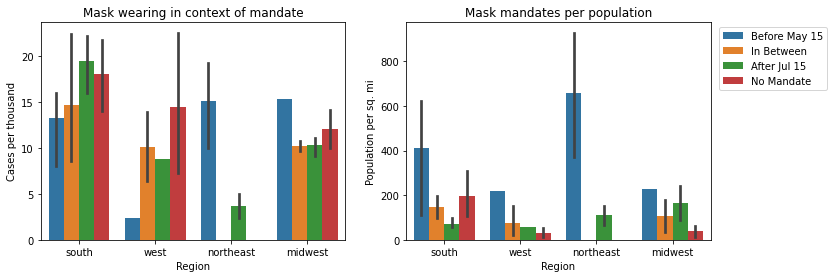

In [160]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

m = sns.barplot(x='region',y='cases_per_thousand',hue='mandate_when',data=df_mand,
             hue_order=['Before May 15','In Between','After Jul 15','No Mandate'], ax=ax1)
ax1.set_title('Mask wearing in context of mandate')
ax1.set_xlabel('Region')
ax1.set_ylabel('Cases per thousand')
ax1.get_legend().remove()

m = sns.barplot(x='region',y='pop_density',hue='mandate_when',data=df_mand,
             hue_order=['Before May 15','In Between','After Jul 15','No Mandate'], ax=ax2)
ax2.set_title('Mask mandates per population')
ax2.set_xlabel('Region')
ax2.set_ylabel('Population per sq. mi')
ax2.legend(bbox_to_anchor=(1.4,1))

__Interpretation:__ States who enacted mask mandates before May 15, 2020 were least hit by covid within their regions than those who mandated masks after July.  With the exception being the Northeast. States without a mandate have the highest cases of them all.

In [146]:
df_mand.groupby(['region','mandate_when']).mean()

covid_cases  covid_deaths  covid_per_density  \
region    mandate_when                                                    
midwest   After Jul 15    74578.433333   2346.383333         546.623747   
          Before May 15  194028.866667   7832.600000         850.097918   
          In Between      63704.933333   3448.500000         709.479114   
          No Mandate      30551.240000    580.920000         826.151182   
northeast After Jul 15     4126.500000    238.433333          33.134284   
          Before May 15  132700.047619   9989.304762         275.658586   
south     After Jul 15    71163.888889   1388.000000         965.800563   
          Before May 15   48853.044444   1650.177778         166.911503   
          In Between     173957.786667   3525.706667        1377.641503   
          No Mandate     195848.106667   3193.013333         879.079370   
west      After Jul 15    50269.933333   1866.600000         904.725695   
          Before May 15    3320.066667     31.133333          15.061240   
          In Between     121363.877778   2344.255556        1192.286633   
          No Mandate      64116.050000   1174.516667        1410.902955   

                           population  pop_density  cases_per_thousand  \
region    mandate_when                                                   
midwest   After Jul 15   7.470846e+06   163.079524           10.308654   
          Before May 15  1.267182e+07   228.242962           15.311838   
          In Between     6.450086e+06   106.134775           10.164427   
          No Mandate     2.574725e+06    38.732013           12.021431   
northeast After Jul 15   9.918500e+05   109.785952            3.666491   
          Before May 15  7.714158e+06   656.402076           15.096950   
south     After Jul 15   3.632379e+06    72.745559           19.466267   
          Before May 15  3.829039e+06   411.861547           13.239633   
          In Between     1.089208e+07   145.004106           14.705866   
          No Mandate     9.606004e+06   195.940766           18.000668   
west      After Jul 15   5.758736e+06    55.563729            8.729335   
          Before May 15  1.415872e+06   220.437802            2.344892   
          In Between     9.598436e+06    77.475941           10.099953   
          No Mandate     3.212625e+06    32.669386           14.480228   

                         mask_wearer  
region    mandate_when                
midwest   After Jul 15     65.873273  
          Before May 15    72.704082  
          In Between       70.562018  
          No Mandate       57.952305  
northeast After Jul 15     80.406538  
          Before May 15    88.883751  
south     After Jul 15     70.074280  
          Before May 15    84.001652  
          In Between       76.404580  
          No Mandate       69.304101  
west      After Jul 15     79.688889  
          Before May 15    92.980000  
          In Between       78.517804  
          No Mandate       66.465934

In [ ]:
m = sns.lineplot(x='date',y='cases',hue='mandate_when',data=df_mand,
             hue_order=['Before May 15','In Between','After Jul 15','No Mandate'])

handles, labels = m.get_legend_handles_labels()
m.legend(bbox_to_anchor=(1,1),title='Mandates enacted',handles=handles[1:], labels=labels[1:])

plt.title('Positive cases in context of mandate')
plt.xlabel('Date')
plt.ylabel('Positive cases')

# plt.savefig('exports/cases_madate.png', dpi=300, bbox_inches='tight')

__Interpretation:__ Mask mandated seem to have been enacted as reactionary, not preventative, measures. Mandates went into effect around the time that cases increased.

In [ ]:
a = sns.lineplot(x='date',y='deaths',hue='mandate_when',data=df_states,
             hue_order=['Before May 15','In Between','After Jul 15','No Mandate'])

plt.title('Deaths in context of mandate')
plt.xlabel('Date')
plt.ylabel('Deaths')

handles, labels = a.get_legend_handles_labels()
a.legend(bbox_to_anchor=(1.38,1),title='Mandates enacted',handles=handles[1:], labels=labels[1:])

#plt.savefig('exports/deaths_mandate.png', dpi=300, bbox_inches='tight')

__Interpretation:__ Mandates went into effect around the time that deaths increased.

In [ ]:
o = sns.lineplot(x='date',y='cases_per_million',hue='mandate_when',data=df_states,
             hue_order=['Before May 15','In Between','After Jul 15','No Mandate'])

handles, labels = o.get_legend_handles_labels()
o.legend(bbox_to_anchor=(1.38,1),title='Mandates enacted',handles=handles[1:], labels=labels[1:])

plt.title('Positive cases per million in context of mandate')
plt.xlabel('Date')
plt.ylabel('Positive cases per million')

# plt.savefig('exports/cases_madate.png', dpi=300, bbox_inches='tight')

In [ ]:
month_map = {
    1:'Jan',
    2:'Feb',
    3:'March',
    4:'April',
    5:'May',
    6:'June',
    7:'July',
    8:'Aug',
    9:'Sept',
    10:'Oct',
    11:'Nov',
    12:'Dec'
}

In [ ]:
df_states['month_case'] = df_states['date'].dt.month

In [ ]:
df_states['month_case_name'] = df_states['month_case'].map(month_map)

In [ ]:
df_cat_graph = df_states[df_states['month_case'] >= 7]

In [ ]:
df_cat_graph = df_cat_graph.groupby('state').mean().reset_index()
df_cat_graph['pop_size'] = df_cat_graph['popestimate2019'].map(pop_size_cat)
df_cat_graph = df_cat_graph.merge(df_states[['state','mandate_when']],on='state')
df_cat_graph['month_case_name'] = df_cat_graph['month_case'].map(month_map)

In [ ]:
sns.barplot(x='mandate_when',y='cases_per_thousand',hue='pop_size',
            data=df_cat_graph, hue_order=state_order, 
            order=[
                'No Mandate',
                'Before May 15',
                'In Between',
                'After Jul 15'
            ])
plt.title('State population size and mask mandate vs cases since July')
plt.ylabel('Cases per Thousand')
plt.xlabel('Date of Mask Mandate')

__Interpretation:__ More evidence that mandates were reactionary with some additional insights: 

* Those who enacted mandates before May have less cases per thousand than those who enacted mandates between May and Jul. 
* States who enacted mandates after Jul are doing better than either early mandaters, although this may be due to lack of data.
* States who have no mandate are overtaking the late adopters

NOTE: The `In Between` category might be too broad, given the ginormous confidence interval.

# Hypothesis Testing

__Idea:__ The main reason for adherence to masks is a sense of danger. 

__Hypothesis:__ Mask wearing is affected by both early mask orders and higher cases per million.

In [ ]:
db = h.db_load_table('covid_states',db='covid.db')

In [ ]:
abbrev = pd.read_csv('data/abbrevs.csv')

In [ ]:
abbrev.head()

In [ ]:
db = db.merge(abbrev, left_on='state',right_on='Abbreviation')

In [ ]:
db = db[['date','State','positiveIncrease','positive','negative','death','totalTestResults']]

In [ ]:
db = db[['date','State','positiveIncrease','positive','negative','death','totalTestResults']]
db.columns = ['date','state','new_positive','total_positive','total_negative','total_death','total_test_results']
db.head()

In [ ]:
list_diff(list(df_states['state'].unique()),list(db['state'].unique()))

In [ ]:
df_states = df_states.merge(db, on=['state','date'], suffixes=('_nyt','_ct'))

In [ ]:
df_states['new_pos_hundred'] = (df_states['new_positive']/df_states['popestimate2019']) * 100
df_states['new_pos_thousand'] = (df_states['new_positive']/df_states['popestimate2019']) * 1000
df_states['new_pos_hthousand'] = (df_states['new_positive']/df_states['popestimate2019']) * 100000
df_states['new_pos_million'] = (df_states['new_positive']/df_states['popestimate2019']) * 1000000

In [ ]:
sns.lineplot(x='date',y='new_pos_million',data=df_states)

In [ ]:
df_graph = df_states[(df_states['state']=='Ohio')|
              (df_states['state']=='Massachusetts')|
              (df_states['state']=='Texas')]

In [ ]:
df_graph = df_graph[['state','date','new_pos_million','mask_wearer']]
df_graph.head()

In [ ]:
def graph_case_v_mask(state):
    k = sns.lineplot(x='date',y='mask_wearer',data=df_states[df_states['state']==state], color='red',label='Mask Wearing')
    plt.title(f'New Cases vs Mask Wearing in {state}')
    plt.ylabel('Mask wearing (%)')
    plt.legend(bbox_to_anchor = (1.445,0.9))
    ax = k.twinx()
    sns.lineplot(x='date',y='new_pos_million',data=df_states[df_states['state']==state],ax=ax, label = 'New Cases per Million')
    plt.ylabel('New cases per million')
    plt.xlabel('Date')
    plt.legend(bbox_to_anchor = (1.1,1))


In [ ]:
graph_case_v_mask('Ohio')
plt.ylim(0,700)

In [ ]:
graph_case_v_mask('Texas')
plt.ylim(0,700)

In [ ]:
graph_case_v_mask('California')
plt.ylim(0,700)

In [ ]:
graph_case_v_mask('Florida')
plt.ylim(0,700)

In [ ]:
df